In [1]:
!pip install rbo
import pickle
import os
import glob
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from scipy.stats import kurtosis, skew
#from sklearn.metrics import plot_confusion_matrix

import seaborn as sns
import os
import pickle
import numpy as np
import cv2
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
from skimage.segmentation import quickshift, mark_boundaries
from skimage.measure import regionprops
import copy
import random
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from skimage import filters
import pandas as pd
import warnings
import tensorflow as tf
import pickle
from scipy.stats import kendalltau
import sys
import scipy.stats as stats
from scipy.stats import wilcoxon
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from functools import partial
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
import time
from sklearn.utils import resample
from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity
import csv
import rbo

import matplotlib.colors as mcolors
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer

In [2]:
from sklearn.metrics import roc_curve, auc
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
import shutil
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.exceptions import DataConversionWarning

In [ ]:
#!mkdir res_sal_resnet_oxpets
#!cp drive/MyDrive/PhD/Results/sanity/res_sal_metrics/oxpets/resnet50/* res_sal_resnet_oxpets/
#!pip install rbo
#!pip install ImbalancedLearningRegression

#!rm -rf res_cams
#!cp drive/MyDrive/PhD/Results/sanity/oxpets_inception.tar.gz .
#!tar -xzvf oxpets_inception.tar.gz
#!ls res_cams/oxpets/inception_v3/ | wc -l

#!rm -rf res_cams
#!cp drive/MyDrive/PhD/Results/sanity/oxpets_xception.tar.gz .
#!tar -xzvf oxpets_xception.tar.gz
#!ls res_cams/oxpets/xception/ | wc -l

#!rm -rf res_cams
#!mkdir res_cams/
#!cp drive/MyDrive/PhD/Results/sanity/res_sal_metrics/oxpets/resnet50/* res_cams/
#!ls res_cams | wc -l

1428


In [3]:
def remove_highly_correlated_features_pd(X, threshold):
    # Convert X to a pandas DataFrame
    # Calculate the correlation matrix
    df = pd.DataFrame(X)
    corr_matrix = df.corr().abs()
    # Create a mask to remove the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set the upper triangle values to NaN
    corr_matrix.mask(mask, inplace=True)

    # Find the highly correlated features
    cols_to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > threshold)]

    # Drop the highly correlated features from the DataFrame
    reduced_df = df.drop(columns=cols_to_drop)

    # Convert the reduced DataFrame back to numpy array
    X_reduced = reduced_df.to_numpy()

    return X_reduced, cols_to_drop


def min_max_scaling1(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def exponential_weightage(x):
    center = 0.5
    steepness = 20.0
    decay_rate = 10.0
        # Calculate the penalty using mirrored Gaussian components
    left_gaussian = np.exp(-steepness * (x - center) ** 2)
    sample_weight = 1-left_gaussian
    return sample_weight

def min_max_scaling(x):
    # Check if x is a single value
    if isinstance(x, (int, float)):
        # If x is a single value, return 0 (or any other default value)
        return 0  # You can choose any default value here
    # If x is iterable (e.g., Pandas Series or NumPy array), apply min-max scaling
    min_val = np.min(x)
    max_val = np.max(x)
    scaled_values = (x - min_val) / (max_val - min_val)
    return scaled_values

def cor_to_01(x):
    return (x+1)/2


def populate_data(dataset_name, model_name, pp="pixel"):
  # Remove the directory if it exists
  if os.path.exists('res_sal_metrics'):
      shutil.rmtree('res_sal_metrics')

  # Create a new directory
  os.mkdir('res_sal_metrics')

  #build the src string
  if pp == "pixel":
    base_dir = "drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/" # change just the dir name as needed
  elif pp == "patch":
    base_dir = "drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics_patch/" # change just the dir name as needed
  else:
    print("Error Unknown pp")
    return -1

  src_dir = base_dir + dataset_name + "/" + model_name + "/*.pkl"
  # Copy files from a specified source directory to the target directory
  source_files = glob.glob(src_dir)
  for file in source_files:
      shutil.copy(file, 'res_sal_metrics/') # dont change this

  print("Data populated from: " + src_dir)


def calculate_rocs_rf(X, y, df):
    roc_dict = {}
    threshold = 0.8

    # Define the pipeline with RandomForestClassifier and BorderlineSMOTE
    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('scaler', MinMaxScaler()),  # Include scaling to handle feature variance
        ('classifier', RandomForestClassifier())
    ])

    # Define the parameter grid for RandomForest
    param_grid = {
        'classifier__n_estimators': [100, 200, 500],  # number of trees
        'classifier__max_depth': [None, 10, 20],      # maximum depth of the tree
        'classifier__min_samples_split': [2, 5, 10],  # minimum number of samples required to split an internal node
        'classifier__min_samples_leaf': [1, 2, 4],    # minimum number of samples required to be at a leaf node
        'classifier__bootstrap': [True, False],       # whether bootstrap samples are used when building trees
    }

    pert_types = ["IT", "IN", "U0", "U1", "U.5", "FR", "G3", "G9", "G15"]

    for pert_type in pert_types:
        df_pert_pair = df[df['pert_key_pair'].str.contains(pert_type)]
        df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
        df_pert_pair.reset_index(drop=True, inplace=True)
        df_pert_rest.reset_index(drop=True, inplace=True)

        X_train = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1','med2','mu1','mu2','kurt1','kurt2','skew1', 'skew2', 'prob_diffs_cor']]
        y_train = (df_pert_rest['cam_rank_target'] > 0.5).astype(int)
        X_train = X_train.dropna(axis=1, how='any')
        columns_to_keep = X_train.columns
        X_train, removed_feature_names = remove_highly_correlated_features_pd(X_train, threshold)

        X_train = pipeline.named_steps['scaler'].fit_transform(X_train)

        X_test = df_pert_pair[columns_to_keep]
        X_test = X_test.drop(columns=removed_feature_names)
        X_test = pipeline.named_steps['scaler'].transform(X_test)
        y_test = (df_pert_pair['cam_rank_target'] > 0.5).astype(int)

        # Grid search with cross-validation
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        y_prob_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)
        roc_dict[pert_type] = [grid_search.best_score_, roc_auc]
        print(f"{pert_type} : {grid_search.best_score_} : {roc_auc}")

    return roc_dict


def calculate_rocs_lgbm(X, y, df):
    roc_dict = {}
    threshold = 0.8

    # Define the pipeline with LGBMClassifier and BorderlineSMOTE
    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('scaler', MinMaxScaler()),  # Ensure scaler is used properly
        ('classifier', LGBMClassifier())
    ])

    # Define the parameter grid for LightGBM
    param_grid = {
        'classifier__n_estimators': [200, 500, 800],
        'classifier__max_depth': [6, 9, 12],
        'classifier__learning_rate': [0.01, 0.1, 0.3],
        'classifier__colsample_bytree': [0.5, 0.75, 1.0],
    }

    pert_types = ["IT", "IN", "U0", "U1", "U.5", "FR", "G3", "G9", "G15"]

    for pert_type in pert_types:
        df_pert_pair = df[df['pert_key_pair'].str.contains(pert_type)]
        df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
        df_pert_pair.reset_index(drop=True, inplace=True)
        df_pert_rest.reset_index(drop=True, inplace=True)

        X_train = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1','med2','mu1','mu2','kurt1','kurt2','skew1', 'skew2', 'prob_diffs_cor']]
        y_train = (df_pert_rest['cam_rank_target'] > 0.5).astype(int)
        X_train = X_train.dropna(axis=1, how='any')
        columns_to_keep = X_train.columns
        X_train, removed_feature_names = remove_highly_correlated_features_pd(X_train, threshold)

        X_train = pipeline.named_steps['scaler'].fit_transform(X_train)

        X_test = df_pert_pair[columns_to_keep]
        X_test = X_test.drop(columns=removed_feature_names)
        X_test = pipeline.named_steps['scaler'].transform(X_test)
        y_test = (df_pert_pair['cam_rank_target'] > 0.5).astype(int)

        # Grid search with cross-validation
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        y_prob_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)
        roc_dict[pert_type] = [grid_search.best_score_, roc_auc]
        print(f"{pert_type} : {grid_search.best_score_} : {roc_auc}")

    return roc_dict


def calculate_rocs_xgb(X,y, df):

    roc_dict = {}
    threshold = 0.8
    # Define the pipeline
    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('classifier', xgb.XGBClassifier())
    ])

    # Define the parameter grid
    param_grid = {
        'classifier__n_estimators': [500, 800],  # number of trees
        #'classifier__max_depth': [6, 9],
        'classifier__colsample_bytree': [0.5, 0.75],
        'classifier__reg_alpha': [0.1, 0.5],
        'classifier__reg_lambda': [0.1, 0.5],
    }

    grid_searches = []
    remove_perts = ["FR", "G3"]

    df = df[~df['pert_key_pair'].str.contains('|'.join(remove_perts))]

    pert_types = ["IT", "IN", "U0", "U1", "U.5", "G9", "G15"] #["IT", "IN", "U0", "U1", "U.5", "FR", "G4", "G6", "G8"]
    pert_groups = [["IT", "IN"], ["U0","U1","U.5"], ["G9", "G15"]]
    pert_key_pairs = np.unique(df['pert_key_pair'])
    print(pert_key_pairs)
    #pert_key_pairs = pert_key_pairs[0:3]
    for pert_type in pert_types:
      df_pert_pair = df[df['pert_key_pair'].str.contains(pert_type)]
      df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
      df_pert_pair.reset_index(drop=True, inplace=True)
      df_pert_rest.reset_index(drop=True, inplace=True)

      X = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1','med2','mu1','mu2','kurt1','kurt2','skew1', 'skew2', 'prob_diffs_cor']] #'prob_diffs_cor',
      #X = df_pert_rest[['Similarity', 'arppd1', 'arppd2']] #'prob_diffs_cor',
      y = df_pert_rest['cam_rank_target']
      y = (y>0.5).astype(int)
      X = X.dropna(axis=1, how='any')
      columns_to_keep = X.columns
      X_reduced, removed_feature_names = remove_highly_correlated_features_pd(X, threshold)
      scaler = MinMaxScaler()
      X = scaler.fit_transform(X_reduced)

      X_test = df_pert_pair[columns_to_keep]
      #X_test = df_pert_pair[['Similarity', 'arppd1', 'arppd2']] #'prob_diffs_cor',
      X_test = X_test.drop(columns=removed_feature_names)
      #print(X_test.columns)
      X_test = scaler.transform(X_test)  # Use the same scaler fitted on training data
      y_test = df_pert_pair['cam_rank_target']
      y_test = (y_test>0.5).astype(int)

      #grid search
      cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
      grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
      grid_search.fit(X, y)

      y_prob_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
      fpr, tpr, _ = roc_curve(y_test, y_prob_test)
      roc_auc = auc(fpr, tpr)
      roc_dict[pert_type] = [grid_search.best_score_, roc_auc]
      print(f"{pert_type} : {grid_search.best_score_} : {roc_auc}")

    return roc_dict


def get_XY(metric = "faithfulness", sal_met_dir = 'res_sal_metrics/'):

  #sal_met_dir = 'res_sal_metrics/'#'res_cams/oxpets/xception/' #"res_sal_resnet_oxpets/"

  files = os.listdir(sal_met_dir)

  f1_scores_0 = []
  f1_scores_1 = []

  model = None
  class_threshold = None

  if metric == "faithfulness":
    dict_idx = 0
  elif metric == "aopc":
    dict_idx = 2
  else:
    print("Uknown Metric")
    return

  tr_files = files[0:500]
  data_arr = []
  for file in tr_files:
      file_path = sal_met_dir + file
      with open(file_path, 'rb') as f:
          data = pickle.load(f)
      faithfulness_dict = data[dict_idx] # 0 for faithfulness and 2 for aopc
      prob_diff_dict = data[3]

      cam_ranks_dict = {}
      arppd_dict = {}
      for key in faithfulness_dict.keys():
          cam_indices= np.argsort(np.array(list(faithfulness_dict[key].values())).flatten())[::-1]
          cam_ranks = np.array(list(faithfulness_dict[key].keys()))[cam_indices]
          #print(key + str(" : ") + str(cam_ranks))
          cam_ranks_dict[key] = cam_ranks
          prob_diffs = prob_diff_dict[key]
          arppd_dict[key] = len(prob_diffs[prob_diffs>=0])/len(prob_diffs)

      cam_res_dict = {}
      for key1, key2 in itertools.combinations(cam_ranks_dict.keys(), 2):
          similarity = rbo.RankingSimilarity(list(cam_ranks_dict[key1]), list(cam_ranks_dict[key2])).rbo_ext(p=0.2)
          # print(f"RBO similarity between {key1} and {key2}: {similarity}")
          res_key = key1 + '_' + key2
          cam_res_dict[res_key] = similarity

      for key1, key2 in itertools.combinations(prob_diff_dict.keys(), 2):
          similarity = rbo.RankingSimilarity(list(np.argsort(prob_diff_dict[key1])[::-1]),
                                            list(np.argsort(prob_diff_dict[key2])[::-1])).rbo_ext(p=0.2)
          # print(f"Perturbation Pixel RBO similarity between {key1} and {key2}: {similarity}")
          res_key = key1 + '_' + key2
          arppd1= arppd_dict[key1]
          arppd2=arppd_dict[key2]

          var1 = np.var(prob_diff_dict[key1])
          var2 = np.var(prob_diff_dict[key2])
          med1 = np.mean(prob_diff_dict[key1])
          med2 = np.mean(prob_diff_dict[key2])
          mu1 = np.mean(prob_diff_dict[key1])
          mu2 = np.mean(prob_diff_dict[key2])
          kurt1 = kurtosis(prob_diff_dict[key1])
          kurt2 =  kurtosis(prob_diff_dict[key2])
          skew1 = skew(prob_diff_dict[key1])
          skew2 = skew(prob_diff_dict[key2])
          #cv1 = var1/mu1
          #cv2 = var2/mu2

          if np.isnan(var1) or np.isnan(var2):
              print("var nan")

          # Check if both variables have zero variance
          if var1 == 0 and var2 == 0:
              prob_diffs_cor = 1  # Assign correlation coefficient as 1 if both have no variance
          elif var1 == 0 or var2 == 0:
              prob_diffs_cor = 0  # Assign correlation coefficient as 0 if one has no variance
          else:
              # Calculate the correlation coefficient using np.corrcoef
              prob_diffs_cor = np.corrcoef(prob_diff_dict[key1], prob_diff_dict[key2])[0, 1]

          if np.isnan(prob_diffs_cor):
              print("Nan")

          cam_rank_target = cam_res_dict[res_key]
          data_arr.append([res_key, similarity, arppd1, arppd2, prob_diffs_cor, var1, var2, med1, med2, mu1, mu2, kurt1, kurt2, skew1, skew2, cam_rank_target])

  df = pd.DataFrame(data_arr, columns=['pert_key_pair','Similarity', 'arppd1', 'arppd2', 'prob_diffs_cor', 'var1', 'var2','med1','med2', 'mu1', 'mu2','kurt1','kurt2',
                                      'skew1', 'skew2', 'cam_rank_target'])
  X = df[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2','prob_diffs_cor', 'med1','med2','mu1','mu2','kurt1','kurt2','skew1', 'skew2']] #'prob_diffs_cor',
  y = df['cam_rank_target']
  y = (y>0.5).astype(int)

  return X, y, df

In [4]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline to handle SMOTE only for RF
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def calculate_rocs_pert_rf(df):

    roc_dict = {}
    threshold = 0.8

    # Define the pipeline
    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('classifier', RandomForestClassifier())
    ])

    # Define the parameter grid
    param_grid = {
        #'classifier__n_estimators': [500, 800],  # number of trees
        'classifier__max_depth': [6, 9],  # depth of trees
        'classifier__min_samples_split': [5, 10],
        'classifier__min_samples_leaf': [2, 4]
    }

    remove_perts = ["FR", "G3"]

    df = df[~df['pert_key_pair'].str.contains('|'.join(remove_perts))]

    pert_types = ["IT", "IN", "U0", "U1", "U.5", "G9", "G15"]
    pert_groups = [["IT", "IN"], ["U0", "U1", "U.5"], ["G9", "G15"]]
    pert_key_pairs = np.unique(df['pert_key_pair'])
    print(pert_key_pairs)

    for pert_type in pert_types:
        df_pert_pair = df[df['pert_key_pair'].str.contains(pert_type)]
        df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
        df_pert_pair.reset_index(drop=True, inplace=True)
        df_pert_rest.reset_index(drop=True, inplace=True)

        X = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
        y = df_pert_rest['cam_rank_target']
        y = (y > 0.5).astype(int)
        X = X.dropna(axis=1, how='any')
        columns_to_keep = X.columns
        X_reduced, removed_feature_names = remove_highly_correlated_features_pd(X, threshold)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X_reduced)

        X_test = df_pert_pair[columns_to_keep]
        X_test = X_test.drop(columns=removed_feature_names)
        X_test = scaler.transform(X_test)
        y_test = df_pert_pair['cam_rank_target']
        y_test = (y_test > 0.5).astype(int)

        # Grid search
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X, y)

        y_prob_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)
        roc_dict[pert_type] = [grid_search.best_score_, roc_auc]
        print(f"{pert_type} : {grid_search.best_score_} : {roc_auc}")

    return roc_dict

In [5]:
# Final model creation irrespective of perturbation
def calculate_rocs_xgb_allpert(df, plot_title, save_dir="/content/drive/MyDrive/PhD/Results/sanity/FRIES/plots_rf/", pp="pixel", metric="faithfulness"):

    roc_dict = {}
    threshold = 0.8

    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('classifier', xgb.XGBClassifier())
    ])

    # Define the parameter grid
    param_grid = {
        #'classifier__n_estimators': [500, 800],  # number of trees
        #'classifier__max_depth': [6, 9],
        #'classifier__colsample_bytree': [0.5, 0.75],
        #'classifier__reg_alpha': [0.1, 0.5],
        'classifier__reg_lambda': [0.1, 0.5],
    }

    remove_perts = ["FR", "G3", "U0", "U1", "U.5"]
    df = df[~df['pert_key_pair'].str.contains('|'.join(remove_perts))]

    X = df[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
    y = df['cam_rank_target']
    y = (y > 0.5).astype(int)
    X = X.dropna(axis=1, how='any')
    X_reduced, removed_feature_names = remove_highly_correlated_features_pd(X, threshold)
    columns_to_keep = [col for col in X.columns if col not in removed_feature_names]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X_reduced)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X, y)

    # Retrieve the best parameters
    best_params = grid_search.best_params_

    # Now perform cross-validation using the best parameters to calculate ROC-AUC on each fold
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fprs = []
    tpr_list = []
    feature_importances = []

    y = y.values if isinstance(y, pd.Series) else y
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the model with the best parameters
        model = xgb.XGBClassifier(**{k.split('__')[1]: v for k, v in best_params.items()}) #RandomForestClassifier(**{k.split('__')[1]: v for k, v in best_params.items()})
        model.fit(X_train, y_train)

        # Calculate ROC-AUC on the test set for each split
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        fprs.append(fpr)
        tpr_list.append(tpr)

        # Save feature importances
        importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': columns_to_keep,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        feature_importances.append(importance_df)

    # Calculate the mean and standard deviation of the true positive rates
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Save the ROC curve data and feature importances to a pickle file
    data_to_save = {
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "tprs": tprs,
        "aucs": aucs,
        "fprs": fprs,
        "tpr_list": tpr_list,
        "best_params": best_params,
        "feature_importances": feature_importances,
        "cv": cv
    }

    pkl_filename = save_dir + "/" + 'roc_curve_rf_' + plot_title + "_" + pp + "_" + metric + '.pkl'
    with open(pkl_filename, 'wb') as f:
        pickle.dump(data_to_save, f)

    # Plot the mean ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=0.8)

    # Plot the standard deviation of the ROC curves
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                     label=r'$\pm$ 1 std. dev.')

    # Plot settings
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {plot_title}')
    plt.legend(loc="lower right")
    plt.savefig(save_dir + "/" + 'roc_curve_rf_' + plot_title + "_" + pp + "_" + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()

    return 0


def calculate_rocs_rf_allpert(df, plot_title, save_dir="/content/drive/MyDrive/PhD/Results/sanity/FRIES/plots_rf/", pp="pixel", metric="faithfulness"):

    roc_dict = {}
    threshold = 0.8

    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('classifier', RandomForestClassifier())
    ])

    # Define the parameter grid
    param_grid = {
        #'classifier__n_estimators': [500, 800],  # number of trees
        #'classifier__max_depth': [6, 9],
        #'classifier__colsample_bytree': [0.5, 0.75],
        #'classifier__reg_alpha': [0.1, 0.5],
        'classifier__reg_lambda': [0.1, 0.5],
    }

    remove_perts = ["FR", "G3"]
    df = df[~df['pert_key_pair'].str.contains('|'.join(remove_perts))]

    X = df[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
    y = df['cam_rank_target']
    y = (y > 0.5).astype(int)
    X = X.dropna(axis=1, how='any')
    X_reduced, removed_feature_names = remove_highly_correlated_features_pd(X, threshold)
    columns_to_keep = [col for col in X.columns if col not in removed_feature_names]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X_reduced)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X, y)

    # Retrieve the best parameters
    best_params = grid_search.best_params_

    # Now perform cross-validation using the best parameters to calculate ROC-AUC on each fold
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fprs = []
    tpr_list = []
    feature_importances = []

    y = y.values if isinstance(y, pd.Series) else y
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train the model with the best parameters
        model = RandomForestClassifier(**{k.split('__')[1]: v for k, v in best_params.items()}) #RandomForestClassifier(**{k.split('__')[1]: v for k, v in best_params.items()})
        model.fit(X_train, y_train)

        # Calculate ROC-AUC on the test set for each split
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        fprs.append(fpr)
        tpr_list.append(tpr)

        # Save feature importances
        importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': columns_to_keep,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        feature_importances.append(importance_df)

    # Calculate the mean and standard deviation of the true positive rates
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Save the ROC curve data and feature importances to a pickle file
    data_to_save = {
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "tprs": tprs,
        "aucs": aucs,
        "fprs": fprs,
        "tpr_list": tpr_list,
        "best_params": best_params,
        "feature_importances": feature_importances,
        "cv": cv
    }

    pkl_filename = save_dir + "/" + 'roc_curve_rf_' + plot_title + "_" + pp + "_" + metric + '.pkl'
    with open(pkl_filename, 'wb') as f:
        pickle.dump(data_to_save, f)

    # Plot the mean ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=0.8)

    # Plot the standard deviation of the ROC curves
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                     label=r'$\pm$ 1 std. dev.')

    # Plot settings
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {plot_title}')
    plt.legend(loc="lower right")
    plt.savefig(save_dir + "/" + 'roc_curve_rf_' + plot_title + "_" + pp + "_" + metric + '.png', dpi=300, bbox_inches='tight')
    plt.show()

    return 0

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import xgboost as xgb

def compare_meta_model_performance_with_models(pkl_file_1, pkl_file_2, csv_file_1, csv_file_2):
    # Load data from both pickle files
    with open(pkl_file_1, 'rb') as f1:
        data1 = pickle.load(f1)

    with open(pkl_file_2, 'rb') as f2:
        data2 = pickle.load(f2)

    # Load corresponding CSV data
    df1 = pd.read_csv(csv_file_1)
    df2 = pd.read_csv(csv_file_2)

    # Extract features (X) and target (y) from both CSV files
    X1 = df1[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
    y1 = (df1['cam_rank_target'] > 0.5).astype(int)
    X1 = X1.dropna(axis=1, how='any')
    columns_to_keep = X1.columns
    X1_reduced, removed_feature_names = remove_highly_correlated_features_pd(X1, 0.8)
    scaler = MinMaxScaler()
    X1 = scaler.fit_transform(X1_reduced)

    X2 = df2[columns_to_keep]  # Ensure X2 has the same columns as X1
    X2 = X2.drop(columns=removed_feature_names)  # Drop the same features that were removed in X1
    X2 = scaler.transform(X2)  # Use the same scaler fitted on X1 to transform X2
    y2 = (df2['cam_rank_target'] > 0.5).astype(int)

    # Use the CV splits from pkl_file_1 to train
    cv_splits = data1['cv']

    # List to store models for each fold
    trained_models = []

    # Train the meta-model using data from pkl_file_1 (X1, y1)
    for train_idx, _ in cv_splits.split(X1, y1):
        X_train, y_train = X1[train_idx], y1.iloc[train_idx]
        model = xgb.XGBClassifier(**data1['best_params'])
        model.fit(X_train, y_train)
        trained_models.append(model)  # Store the model for each fold

    # Evaluate each trained model on the test splits from pkl_file_2 (X2, y2)
    aucs = []
    for model, (_, test_idx) in zip(trained_models, cv_splits.split(X2, y2)):
        X_test_split, y_test_split = X2[test_idx], y2.iloc[test_idx]
        y_pred_prob = model.predict_proba(X_test_split)[:, 1]
        auc = roc_auc_score(y_test_split, y_pred_prob)
        aucs.append(auc)

    # Calculate the mean and standard deviation of AUCs
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    print(f"Meta-model trained on {pkl_file_1} (train) and tested on {pkl_file_2} (test)")
    print(f"Mean ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")

    return aucs

In [ ]:
pkl_file_1 = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/" + "roc_curve_rf_pvoc_inception_v3_patch_faithfulness.pkl"
pkl_file_2 = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/" + "roc_curve_rf_pvoc_xception_patch_faithfulness.pkl"
csv_file_1 = xy_dir + "pixel_faithfulness_pvoc_inception_v3.csv"
csv_file_2 = xy_dir + "pixel_faithfulness_pvoc_xception.csv"

with open(pkl_file_1, 'rb') as f1:
        data1 = pickle.load(f1)
print(data1.keys())

aucs_1on2 = compare_meta_model_performance_with_models(pkl_file_1, pkl_file_2, csv_file_1, csv_file_2)

dict_keys(['mean_fpr', 'mean_tpr', 'tprs', 'aucs', 'fprs', 'tpr_list', 'best_params', 'feature_importances', 'cv'])
Meta-model trained on /content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/roc_curve_rf_pvoc_inception_v3_patch_faithfulness.pkl (train) and tested on /content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/roc_curve_rf_pvoc_xception_patch_faithfulness.pkl (test)
Mean ROC-AUC: 0.6095 ± 0.0104


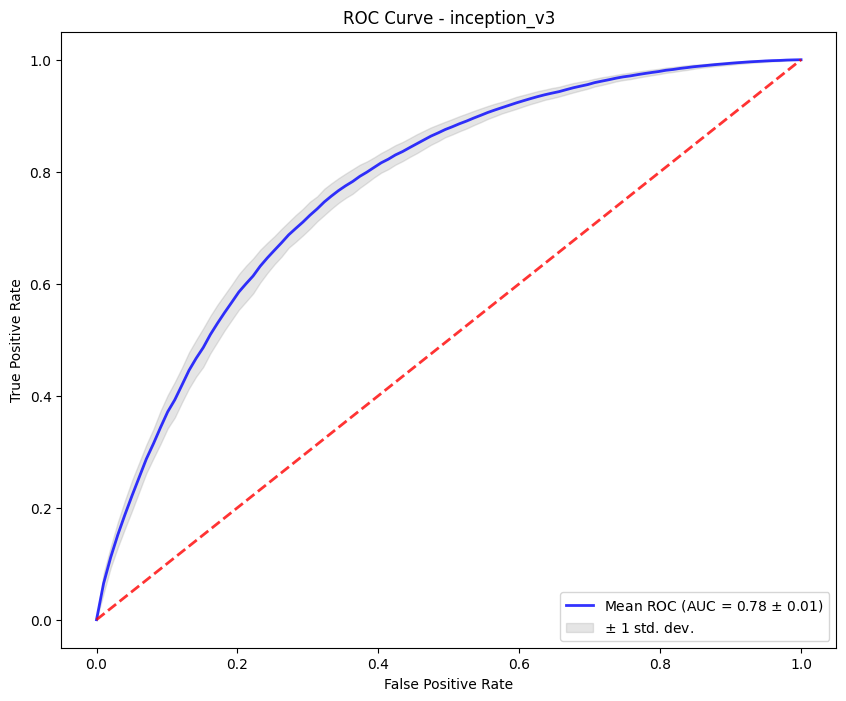

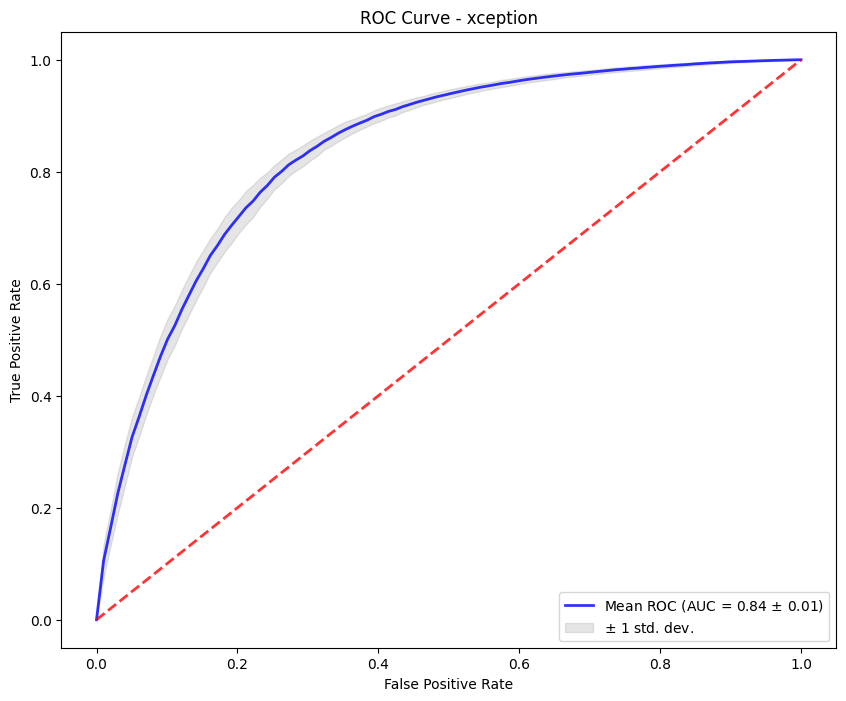

0

In [ ]:
csv_filename1 = xy_dir + "pixel_faithfulness_pvoc_inception_v3.csv"
csv_filename2 = xy_dir + "pixel_faithfulness_oxpets_inception_v3.csv"
csv_filename3 = xy_dir + "pixel_faithfulness_imagenette_inception_v3.csv"

csv_files = [csv_filename1, csv_filename2, csv_filename3]
df_iv3 = read_multiple_csvs(csv_files)

csv_filename1 = xy_dir + "pixel_faithfulness_pvoc_xception.csv"
csv_filename2 = xy_dir + "pixel_faithfulness_oxpets_xception.csv"
csv_filename3 = xy_dir + "pixel_faithfulness_imagenette_xception.csv"

csv_files = [csv_filename1, csv_filename2, csv_filename3]
df_xcp = read_multiple_csvs(csv_files)

calculate_rocs_xgb_allpert(df_iv3, "inception_v3", save_dir=save_dir, pp='pixel', metric='faithfulness')
calculate_rocs_xgb_allpert(df_xcp, "xception", save_dir=save_dir, pp='pixel', metric='faithfulness')

In [ ]:
df_iv3.to_csv('/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/pixel_faithfulness_pvoc_inception_v3.csv', index=False)
df_xcp.to_csv('/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/pixel_faithfulness_pvoc_xception.csv', index=False)

In [ ]:
pkl_file_1 = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/" + "roc_curve_rf_inception_v3_pixel_faithfulness.pkl"
pkl_file_2 = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/" + "roc_curve_rf_xception_pixel_faithfulness.pkl"
csv_file_1 = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/" + "pixel_faithfulness_pvoc_inception_v3.csv"
csv_file_2 = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/" + "pixel_faithfulness_pvoc_xception.csv"

aucs_2on1 = compare_meta_model_performance_with_models(pkl_file_2, pkl_file_1, csv_file_2, csv_file_1)

Meta-model trained on /content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/roc_curve_rf_xception_pixel_faithfulness.pkl (train) and tested on /content/drive/MyDrive/PhD/Results/sanity/FRIES/model_agnostic/roc_curve_rf_inception_v3_pixel_faithfulness.pkl (test)
Mean ROC-AUC: 0.6364 ± 0.0052


In [ ]:
print(aucs_1on2)

with open(pkl_file_2, 'rb') as f1:
        data2 = pickle.load(f1)
print(data2['aucs'])

[0.610850152338423, 0.6176642130558975, 0.6234169764986833, 0.5900621876373582, 0.6122897911341918, 0.6157246061929671, 0.6149998559891604, 0.603201611418682, 0.6025779818696615, 0.6088482451339989, 0.6150834448895561, 0.6075638875913999, 0.6060420686969273, 0.6121647208506407, 0.6164050574102342, 0.606818788029819, 0.6331292553637776, 0.6099031245343127, 0.6183762840444755, 0.59497608793928, 0.5980256740020362, 0.6228335760646471, 0.6246595395910843, 0.5994106825988571, 0.600595641355405, 0.6097810283876671, 0.6199049904138871, 0.6083705048268677, 0.5936524404828245, 0.618785149602217, 0.6265053828747319, 0.5923768488174206, 0.6064499950535407, 0.6039382581701106, 0.6028118429505442, 0.6143774787083104, 0.6104517745266114, 0.6143502418755972, 0.5905283444639102, 0.6025178729974666, 0.5922420734555464, 0.6057482552773712, 0.6098729135646941, 0.6019458995104884, 0.6288159741832394, 0.6084418841125989, 0.5938960066420303, 0.6088163122956455, 0.6272874243473491, 0.6151491889685192]
[0.788

In [ ]:
### Perturbation agnostic final code that uses portion of pert pair in train and compares both models i.e. with and without pert pair samples.
### This code further balances the number of training samples for both models by deleting some samples from model2's training data


from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import numpy as np

import pandas as pd

def delete_samples_uniformly(df_pert_rest, pert_types, num_pert_test_samples):
    # Calculate the number of samples to remove per perturbation type
    samples_per_pert_type = num_pert_test_samples // len(pert_types)

    # Ensure we don't delete more samples than are available
    for pert_type in pert_types:
        # Identify the rows in df_pert_rest that contain the current pert_type
        pert_rest_subset = df_pert_rest[df_pert_rest['pert_key_pair'].str.contains(pert_type)]

        # Randomly select the required number of samples from this subset
        if pert_rest_subset.shape[0] >= samples_per_pert_type:
            samples_to_remove = pert_rest_subset.sample(n=samples_per_pert_type, random_state=42)
        else:
            # If not enough samples available, remove all available samples for this pert_type
            samples_to_remove = pert_rest_subset

        # Drop the selected samples from df_pert_rest
        df_pert_rest = df_pert_rest.drop(samples_to_remove.index) # .index corresponds to pert_rest_subset indices so its fine

    # Return the updated dataframe after removing samples
    return df_pert_rest


def calculate_rocs_pert_agnostic_xgb(df, n_splits=5, n_repeats=20):

    roc_dict = {}
    threshold = 0.8
    pert_test_split = 0.5

    # Define the pipeline
    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('classifier', xgb.XGBClassifier())
    ])

    # Define the parameter grid
    param_grid = {
        #'classifier__n_estimators': [500, 800],
        #'classifier__colsample_bytree': [0.5, 0.75],
        #'classifier__reg_alpha': [0.1, 0.5],
        'classifier__reg_lambda': [0.1, 0.5],
    }

    remove_perts = ["FR", "G3"]

    df = df[~df['pert_key_pair'].str.contains('|'.join(remove_perts))]

    pert_types = ["IT", "IN", "U0", "U1", "U.5", "G9", "G15"]

    for pert_type in pert_types:
        df_pert_pair = df[df['pert_key_pair'].str.contains(pert_type)]
        num_pert_test_samples = int(df_pert_pair.shape[0]*pert_test_split)

        #reduced X and y for balancing
        rest_pert_types = [pt for pt in pert_types if pt != pert_type]
        df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
        df_pert_rest = delete_samples_uniformly(df_pert_rest, rest_pert_types, num_pert_test_samples)
        df_pert_pair.reset_index(drop=True, inplace=True)
        df_pert_rest.reset_index(drop=True, inplace=True)
        X = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
        y = df_pert_rest['cam_rank_target']
        y = (y > 0.5).astype(int)
        X = X.dropna(axis=1, how='any')
        columns_to_keep = X.columns
        X_reduced, removed_feature_names = remove_highly_correlated_features_pd(X, threshold)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X_reduced)

        #original X and y for model 1
        df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
        df_pert_pair.reset_index(drop=True, inplace=True)
        df_pert_rest.reset_index(drop=True, inplace=True)
        X_o = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
        y_o = df_pert_rest['cam_rank_target']
        y_o = (y_o > 0.5).astype(int)
        X_o = X_o.dropna(axis=1, how='any')
        columns_to_keep = X_o.columns
        X_reduced_o, removed_feature_names = remove_highly_correlated_features_pd(X_o, threshold)
        X_o = scaler.fit_transform(X_reduced_o)


        X_test = df_pert_pair[columns_to_keep]
        X_test = X_test.drop(columns=removed_feature_names)
        X_test = scaler.transform(X_test)
        y_test = df_pert_pair['cam_rank_target']
        y_test = (y_test > 0.5).astype(int)

        # Store results for averaging
        model1_roc_aucs = []
        model2_roc_aucs = []

        model1_probs = []
        model2_probs = []
        true_labels = []
        # Perform repeated train-test splits
        for _ in range(n_repeats):
            X_test_train, X_test_eval, y_test_train, y_test_eval = train_test_split(X_test, y_test, test_size=pert_test_split, random_state=None)

            # Train Model 1 on X and y (original data)
            grid_search_model1 = GridSearchCV(pipeline, param_grid, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42), scoring='roc_auc', n_jobs=-1)
            #print("X shape:", str(X_o.shape), " y shape:", str(y_o.shape))
            grid_search_model1.fit(X_o, y_o)

            # Train Model 2 on X, y, and some records from X_test_train
            X_combined = np.concatenate([X, X_test_train])
            y_combined = np.concatenate([y, y_test_train])
            grid_search_model2 = GridSearchCV(pipeline, param_grid, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42), scoring='roc_auc', n_jobs=-1)
            #print("X combined shape:", str(X_combined.shape), " y combined shape:", str(y_combined.shape))
            grid_search_model2.fit(X_combined, y_combined)


            # Evaluate both models on the remaining records of X_test_eval
            y_prob_test_model1 = grid_search_model1.best_estimator_.predict_proba(X_test_eval)[:, 1]
            y_prob_test_model2 = grid_search_model2.best_estimator_.predict_proba(X_test_eval)[:, 1]

            fpr1, tpr1, _ = roc_curve(y_test_eval, y_prob_test_model1)
            fpr2, tpr2, _ = roc_curve(y_test_eval, y_prob_test_model2)

            roc_auc_model1 = auc(fpr1, tpr1)
            roc_auc_model2 = auc(fpr2, tpr2)

            model1_roc_aucs.append(roc_auc_model1)
            model2_roc_aucs.append(roc_auc_model2)
            model1_probs.append(y_prob_test_model1)
            model2_probs.append(y_prob_test_model2)
            true_labels.append(y_test_eval)

        # Average the ROC-AUC scores
        roc_dict[pert_type] = {
            "Model_defs": "Model-1 X,y & Model 2= X,y + pert_test_cv",
            "ROC-AUC1": np.array(model1_roc_aucs),
            "ROC_AUC2": np.array(model2_roc_aucs),
            "Probs1": model1_probs,
            "Probs2": model2_probs,
            "True_Labels": true_labels
        }
        print(f"{pert_type} : Model 1 Avg ROC-AUC = {np.mean(model1_roc_aucs)} : Model 2 Avg ROC-AUC = {np.mean(model2_roc_aucs)}")

    return roc_dict


def calculate_rocs_pert_agnostic_rf(df, n_splits=5, n_repeats=20):

    roc_dict = {}
    threshold = 0.8
    pert_test_split = 0.5

    # Define the pipeline
    pipeline = Pipeline([
        ('borderline_smote', BorderlineSMOTE()),
        ('classifier', RandomForestClassifier())
    ])

    # Define the parameter grid
    param_grid = {
        #'classifier__max_depth': [6, 8, 10],  # depth of trees
        #'classifier__min_samples_split': [5, 10, 15],
        'classifier__min_samples_leaf': [8, 20]
    }

    remove_perts = ["FR", "G3"]

    df = df[~df['pert_key_pair'].str.contains('|'.join(remove_perts))]

    pert_types = ["IT", "IN", "U0", "U1", "U.5", "G9", "G15"]

    for pert_type in pert_types:
        df_pert_pair = df[df['pert_key_pair'].str.contains(pert_type)]
        num_pert_test_samples = int(df_pert_pair.shape[0]*pert_test_split)

        #reduced X and y for balancing
        rest_pert_types = [pt for pt in pert_types if pt != pert_type]
        df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
        df_pert_rest = delete_samples_uniformly(df_pert_rest, rest_pert_types, num_pert_test_samples)
        df_pert_pair.reset_index(drop=True, inplace=True)
        df_pert_rest.reset_index(drop=True, inplace=True)
        X = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
        y = df_pert_rest['cam_rank_target']
        y = (y > 0.5).astype(int)
        X = X.dropna(axis=1, how='any')
        columns_to_keep = X.columns
        X_reduced, removed_feature_names = remove_highly_correlated_features_pd(X, threshold)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X_reduced)

        #original X and y for model 1
        df_pert_rest = df[~df['pert_key_pair'].str.contains(pert_type)]
        df_pert_pair.reset_index(drop=True, inplace=True)
        df_pert_rest.reset_index(drop=True, inplace=True)
        X_o = df_pert_rest[['Similarity', 'arppd1', 'arppd2', 'var1', 'var2', 'med1', 'med2', 'mu1', 'mu2', 'kurt1', 'kurt2', 'skew1', 'skew2', 'prob_diffs_cor']]
        y_o = df_pert_rest['cam_rank_target']
        y_o = (y_o > 0.5).astype(int)
        X_o = X_o.dropna(axis=1, how='any')
        columns_to_keep = X_o.columns
        X_reduced_o, removed_feature_names = remove_highly_correlated_features_pd(X_o, threshold)
        X_o = scaler.fit_transform(X_reduced_o)


        X_test = df_pert_pair[columns_to_keep]
        X_test = X_test.drop(columns=removed_feature_names)
        X_test = scaler.transform(X_test)
        y_test = df_pert_pair['cam_rank_target']
        y_test = (y_test > 0.5).astype(int)

        # Store results for averaging
        model1_roc_aucs = []
        model2_roc_aucs = []

        model1_probs = []
        model2_probs = []
        true_labels = []
        # Perform repeated train-test splits
        for _ in range(n_repeats):
            X_test_train, X_test_eval, y_test_train, y_test_eval = train_test_split(X_test, y_test, test_size=pert_test_split, random_state=None)

            # Train Model 1 on X and y (original data)
            grid_search_model1 = GridSearchCV(pipeline, param_grid, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42), scoring='roc_auc', n_jobs=-1)
            #print("X shape:", str(X_o.shape), " y shape:", str(y_o.shape))
            grid_search_model1.fit(X_o, y_o)

            # Train Model 2 on X, y, and some records from X_test_train
            X_combined = np.concatenate([X, X_test_train])
            y_combined = np.concatenate([y, y_test_train])
            grid_search_model2 = GridSearchCV(pipeline, param_grid, cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1, random_state=42), scoring='roc_auc', n_jobs=-1)
            #print("X combined shape:", str(X_combined.shape), " y combined shape:", str(y_combined.shape))
            grid_search_model2.fit(X_combined, y_combined)


            # Evaluate both models on the remaining records of X_test_eval
            y_prob_test_model1 = grid_search_model1.best_estimator_.predict_proba(X_test_eval)[:, 1]
            y_prob_test_model2 = grid_search_model2.best_estimator_.predict_proba(X_test_eval)[:, 1]

            fpr1, tpr1, _ = roc_curve(y_test_eval, y_prob_test_model1)
            fpr2, tpr2, _ = roc_curve(y_test_eval, y_prob_test_model2)

            roc_auc_model1 = auc(fpr1, tpr1)
            roc_auc_model2 = auc(fpr2, tpr2)

            model1_roc_aucs.append(roc_auc_model1)
            model2_roc_aucs.append(roc_auc_model2)
            model1_probs.append(y_prob_test_model1)
            model2_probs.append(y_prob_test_model2)
            true_labels.append(y_test_eval)

        # Average the ROC-AUC scores
        roc_dict[pert_type] = {
            "Model_defs": "Model-1 X,y & Model 2= X,y + pert_test_cv",
            "ROC-AUC1": np.array(model1_roc_aucs),
            "ROC_AUC2": np.array(model2_roc_aucs),
            "Probs1": model1_probs,
            "Probs2": model2_probs,
            "True_Labels": true_labels
        }
        print(f"{pert_type} : Model 1 Avg ROC-AUC = {np.mean(model1_roc_aucs)} : Model 2 Avg ROC-AUC = {np.mean(model2_roc_aucs)}")

    return roc_dict

In [ ]:
### Perturbation Agnostic test using pairs of pert as test set
warnings.filterwarnings(action='ignore', category=UserWarning)

xy_dir = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/XY/"
save_dir = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/pert_agnostic_new_rf_balanced/" #pert_agnostic_new_xgb_balanced

model_names = ["xception", "resnet50", "inception_v3"]
dataset_names = ["pvoc", "oxpets", "imagenette"]

pps = ["pixel", "patch"]
metrics = ["aopc", "faithfulness"]

for pp in pps:
  for metric in metrics:
    for dataset_name in dataset_names:
        for model_name in model_names:
            pkl_filename = save_dir + pp + "_" + metric + "_" + dataset_name + "_" + model_name + ".pkl"

            if os.path.exists(pkl_filename):
              print("Exists: " + pkl_filename)
              continue

            csv_filename = xy_dir + pp + "_" + metric + "_" + dataset_name + "_" + model_name + ".csv"
            df = pd.read_csv(csv_filename)
            roc_val = calculate_rocs_pert_agnostic_rf(df)

            with open(pkl_filename, 'wb') as file:
              pickle.dump(roc_val, file)

            del df, roc_val

In [ ]:
#debugging
xy_dir = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/XY/"
save_dir = "/content/drive/MyDrive/PhD/Results/sanity/FRIES/pert_agnostic_new_xgb/"

model_names = ["xception", "resnet50", "inception_v3"]
dataset_names = ["pvoc", "oxpets", "imagenette"]
pps = ["pixel", "patch"]
metrics = ["aopc", "faithfulness"]

remove_perts = ['IT']
csv_filename = xy_dir + pps[0] + "_" + metrics[0] + "_" + dataset_names[0] + "_" + model_names[0] + ".csv"

df = pd.read_csv(csv_filename)
df_pert_rest = df[~df['pert_key_pair'].str.contains('|'.join(remove_perts))]

pert_rest_subset = df_pert_rest[df_pert_rest['pert_key_pair'].str.contains('IN')]
samples_to_remove = pert_rest_subset.sample(n=10, random_state=42)

In [ ]:
!rm -rf res_sal_metrics
!mkdir res_sal_metrics
!cp drive/MyDrive/PhD/Results/sanity/FRIES/res_sal_metrics/oxpets/inception_v3/*.pkl res_sal_metrics/